In [14]:
import gzip
import json
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
def load_data(file_name, head = 2000000):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            if count % 500000 == 0:
                print(f"Loaded {count} lines")
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [16]:
def load_valid_items_text(file_name):
    valid_items = set()
    with open(file_name, 'r') as fin:
        for line in fin:
            obj = json.loads(line)
            valid_items.add(obj['asin'])
    return valid_items

In [17]:
def load_valid_items_images(folder_path):
    valid_items = set()
    for entry in os.scandir(folder_path):
        asin = entry.name.split('.')[0]
        valid_items.add(asin)
    return valid_items

In [18]:
def filter_valid_interactions(in_file_name, out_file_name, valid_items):
    count = 0
    filtered_count = 0
    with gzip.open(in_file_name, 'rt') as fin, gzip.open(out_file_name, 'wt') as fout:
        for line in fin:
            obj = json.loads(line)
            count+=1
            if obj['asin'] in valid_items or obj['parent_asin'] in valid_items:
                fout.write(json.dumps(obj) + '\n')
                filtered_count += 1
            if count % 500000 == 0:
                print(f"Processed {count} lines")
    print(f"Total interactions: {count}, Filtered interactions: {filtered_count}")

In [19]:
def clean_mmgb_data(in_file_name, out_file_name, valid_items, in_directory, out_directory):
    with open(in_file_name, 'r') as fin, open(out_file_name, 'w') as fout:
        for line in fin:
            obj = json.loads(line)
            if obj['asin'] in valid_items:
                fout.write(json.dumps(obj) + '\n')
    os.makedirs(out_directory, exist_ok=True)
    for entry in os.scandir(in_directory):
        asin = entry.name.split('.')[0]
        if asin in valid_items:
            shutil.copy(entry.path, os.path.join(out_directory, entry.name))



In [20]:
DIR = '../data/amazon-sports/'
PATH_IN_TO_FULL_RAW_TEXT_ITEMS = os.path.join(DIR, 'sports-raw-text.jsonl')
PATH_OUTIN_TO_FILTERED_0CORE_INTERACTIONS = os.path.join(DIR, 'filtered_sports_interactions.json.gz')
PATH_IN_TO_FULL_INTERACTIONS = os.path.join(DIR, 'Sports_and_Outdoors.jsonl.gz')
PATH_OUT_TO_FINAL_FILTERED_5CORE_INTERACTIONS = os.path.join(DIR, 'sports_5core_interactions.csv')
PATH_IN_TO_5CORE_INTERACTIONS = os.path.join(DIR, 'Sports_and_Outdoors.csv')
PATH_OUT_TO_5CORE_TEXT_ITEMS = os.path.join(DIR, 'sports-5core-raw-text.jsonl')
PATH_IN_TO_FULL_IMAGE_ITEMS = os.path.join(DIR, 'sports-images/')
PATH_OUT_TO_5CORE_IMAGE_ITEMS = os.path.join(DIR, 'sports-5core-images/')

valid_items = load_valid_items_text(PATH_IN_TO_FULL_RAW_TEXT_ITEMS)

'''
The call to filter_valid_interactions was run once in the beginning on the FULL reviews dataset(*.jsonl.gz)
to filter out only the interactions involving items in the MM-Graph dataset.
We cannot directly take the 5-core datasets from Amazon reviews since they use parent_asins only whereas
MM-Graph uses only asin for items. So we initially loaded all the interactions since they included both
asin and parent_asin. Uncomment the following line to re-generate the filtered interactions file if needed.
'''
#filter_valid_interactions(PATH_TO_FULL_INTERACTIONS, PATH_TO_FILTERED_0CORE_INTERACTIONS, valid_items)
fivecore_interactions_df = pd.read_csv(PATH_IN_TO_5CORE_INTERACTIONS)
print("Loaded 5-core interactions dataset")
df = pd.DataFrame(load_data(PATH_OUTIN_TO_FILTERED_0CORE_INTERACTIONS))
print("Loaded filtered full interactions dataset")


Loaded 5-core interactions dataset
Loaded 500000 lines
Loaded 1000000 lines
Loaded 1500000 lines
Loaded filtered full interactions dataset


In [21]:
print(df.columns)
asin_parent_map = df[['asin', 'parent_asin']].drop_duplicates()
print(asin_parent_map.head())
print(fivecore_interactions_df.columns)

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')
         asin parent_asin
0  B000H864AA  B000H864AA
1  B000J2KEGY  B0BX4YQ8C5
2  B00172A3DE  B00172A3DE
3  B00K64XUCK  B00K64XUCK
4  B001NMTH8K  B001NMTH8K
Index(['user_id', 'parent_asin', 'rating', 'timestamp'], dtype='object')


In [22]:
'''
Since MM-Graph dataset uses asin for items whereas the reviews 5-core dataset uses parent_asin,
we first need to merge the 5-core dataset with the ASIN-PARENT_ASIN Map obtained using the 0-core dataset 
on parent_asin to be able to filter the interactions properly and map the multimodal data to the interactions.
'''
print("ASIN to PARENT_ASIN MAP SHAPE: ",asin_parent_map.shape)
print("NUMBER OF FIVECORE INTERACTIONS: ",fivecore_interactions_df.shape)
merged_df = pd.merge(fivecore_interactions_df, asin_parent_map, on='parent_asin', how='inner')
print("NUMBER OF INTERACTIONS AFTER MERGING WITH PARENT_ASIN: ",merged_df.shape)
print(merged_df.columns)
print("NUMBER OF INTERACTIONS ON ITEMS WITHOUT MULTIMODAL DATA: ",len(merged_df[~merged_df['asin'].isin(valid_items) & (~merged_df['parent_asin'].isin(valid_items) & merged_df['asin']!=merged_df['parent_asin'])]))
merged_df = merged_df[~(~merged_df['asin'].isin(valid_items) & (~merged_df['parent_asin'].isin(valid_items) & merged_df['asin']!=merged_df['parent_asin']))]
print("REMAINING NUMBER OF INTERACTIONS AFTER REMOVING INTERACTIONS ON ITEMS WITHOUT MULTIMODAL DATA: ",merged_df.shape)
'''
After filtering out interactions on items without multimodal data, some users would have fallen
under 5 interactions as well so we now apply the 5-core filtering on users only.We are not filtering items 
again since we want to retain as many items as possible for the co-purchase graph.
'''
user_counts = merged_df.groupby("user_id").size()
valid_users = user_counts[user_counts >= 5].index
merged_df = merged_df[merged_df["user_id"].isin(valid_users)]
print("NUMBER OF INTERACTIONS AFTER FILTERING USERS WITH LESS THAN 5 INTERACTIONS: ", merged_df.shape)
merged_df.to_csv(PATH_OUT_TO_FINAL_FILTERED_5CORE_INTERACTIONS, index=False)


ASIN to PARENT_ASIN MAP SHAPE:  (31453, 2)
NUMBER OF FIVECORE INTERACTIONS:  (3472020, 4)
NUMBER OF INTERACTIONS AFTER MERGING WITH PARENT_ASIN:  (788014, 5)
Index(['user_id', 'parent_asin', 'rating', 'timestamp', 'asin'], dtype='object')
NUMBER OF INTERACTIONS ON ITEMS WITHOUT MULTIMODAL DATA:  110611
REMAINING NUMBER OF INTERACTIONS AFTER REMOVING INTERACTIONS ON ITEMS WITHOUT MULTIMODAL DATA:  (677403, 5)
NUMBER OF INTERACTIONS AFTER FILTERING USERS WITH LESS THAN 5 INTERACTIONS:  (217539, 5)


In [23]:
'''
We next clean the MM-Graph data to retain only those items which are 
present in the final filtered 5-core reviews dataset.
'''
print("NUMBER OF ITEMS IN MM-GRAPH:", len(valid_items))
print("NUMBER OF ITEMS IN MM-GRAPH AND IN REVIEWS",len(valid_items & set(merged_df['asin'])))
valid_items = valid_items & set(merged_df['asin'])
clean_mmgb_data(PATH_IN_TO_FULL_RAW_TEXT_ITEMS, PATH_OUT_TO_5CORE_TEXT_ITEMS, valid_items, PATH_IN_TO_FULL_IMAGE_ITEMS, PATH_OUT_TO_5CORE_IMAGE_ITEMS)


NUMBER OF ITEMS IN MM-GRAPH: 50250
NUMBER OF ITEMS IN MM-GRAPH AND IN REVIEWS 12742


In [24]:
'''
We finally verify that the valid items in both the text and image datasets
match with the valid items set obtained after filtering the reviews dataset.
'''
valid_items_text_5core = load_valid_items_text(PATH_OUT_TO_5CORE_TEXT_ITEMS)
valid_items_images_5core = load_valid_items_images(PATH_OUT_TO_5CORE_IMAGE_ITEMS)
if valid_items != valid_items_text_5core or valid_items != valid_items_images_5core:
    print("MISMATCH IN VALID ITEMS AFTER CREATING 5-CORE DATASETS")
else: 
    print("5-CORE DATASETS CREATED SUCCESSFULLY")
print(len(valid_items), len(valid_items_text_5core), len(valid_items_images_5core))

5-CORE DATASETS CREATED SUCCESSFULLY
12742 12742 12742


Interactions from users with >=5 interactions: 217539
Number of users with >=5 interactions: 31111


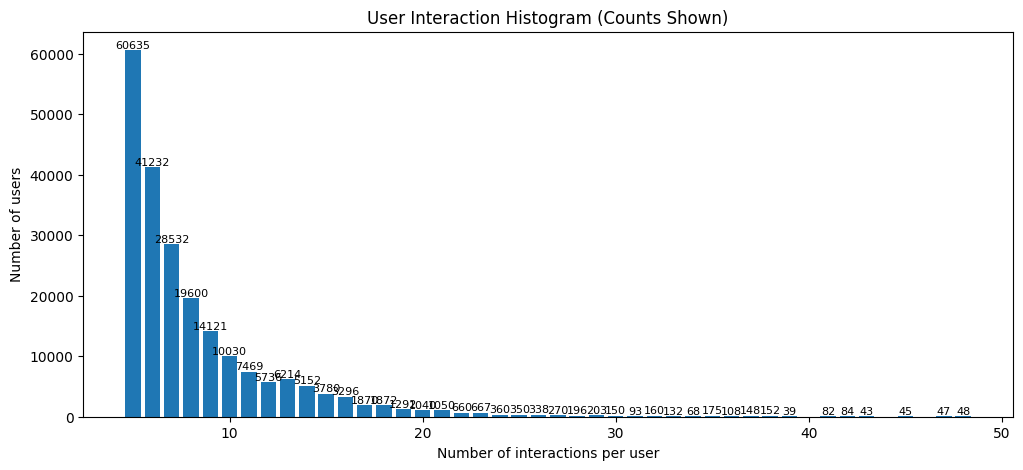

In [25]:
user_counts = merged_df.groupby("user_id").size()
freq = user_counts.value_counts().sort_index()
num_users_5plus = (user_counts >= 5).sum()
interactions_5plus = user_counts[user_counts >= 5].sum()
print("Interactions from users with >=5 interactions:", interactions_5plus)
print("Number of users with >=5 interactions:", num_users_5plus)
plt.figure(figsize=(12,5))
bars = plt.bar(freq.index, freq.values*freq.index)

plt.xlabel("Number of interactions per user")
plt.ylabel("Number of users")
plt.title("User Interaction Histogram (Counts Shown)")

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        str(height),
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.show()

Interactions from items with >=0 interactions: 217539
Number of items with >=0 interactions: 12742


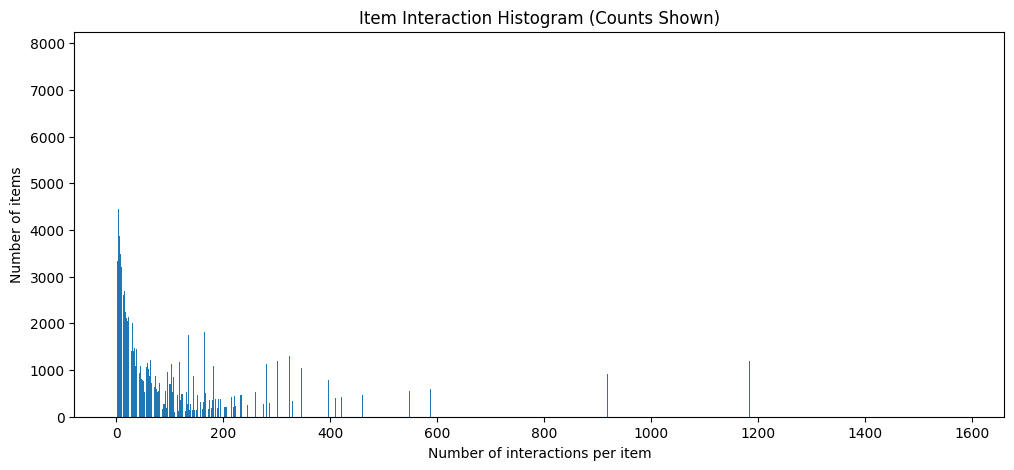

In [26]:
# Count interactions per item
item_counts = merged_df.groupby("asin").size()

# Count how many items have each number of interactions
freq = item_counts.value_counts().sort_index()

num_items_5plus = (item_counts >= 0).sum()
interactions_5plus = item_counts[item_counts >= 0].sum()
print("Interactions from items with >=0 interactions:", interactions_5plus)
print("Number of items with >=0 interactions:", num_items_5plus)

plt.figure(figsize=(12,5))
bars = plt.bar(freq.index, freq.values*freq.index)

plt.xlabel("Number of interactions per item")
plt.ylabel("Number of items")
plt.title("Item Interaction Histogram (Counts Shown)")

plt.show()
